In [852]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, KFold
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

In [853]:
numeric_df = pd.read_csv("../data/items_processed.csv")
numeric_df.head()

,num_images,mileage,price,date_idx,category_app,category_art,category_atq,category_avo,category_bab,category_bfd,...,location_woonsocket,"location_woonsocket ,r.i.",location_woonsocket ri,"location_woonsocket, ri",location_ww/ coventry,location_ww/cov,location_ww/coventry,location_www.smdwoods.com,location_wyoming,"location_🇺🇸#piano mover and tuning ..ri,ma.,ct, insured!"
0,1,0.0,5.0,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,0.0,4.0,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,0.0,7.0,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,0.0,3.0,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,0.0,5.0,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [854]:
with open("../data/reduced_features.npy", "rb") as image_npy:
    image_features = np.load(image_npy)

In [855]:
with open("../data/text_embeds.npy", "rb") as text_npy:
    text_features = np.load(text_npy)

In [856]:
assert text_features.shape[0] == numeric_df.shape[0]
assert image_features.shape[0] == numeric_df.shape[0]

In [857]:
target = numeric_df["price"].values

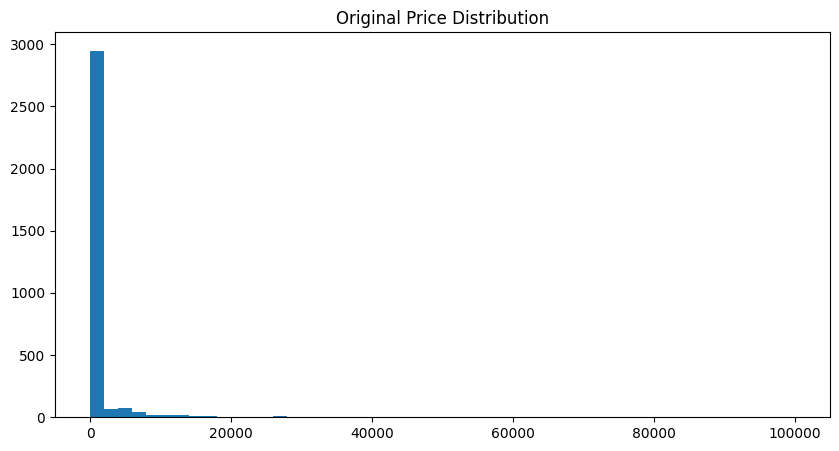

In [858]:
plt.figure(figsize=(10, 5))
plt.hist(target, bins=50)
plt.title("Original Price Distribution")
plt.show()
#it is very skewed

In [859]:
#price stats
print("Target statistics:")
print(f"Min price: ${np.min(target):,.2f}")
print(f"Max price: ${np.max(target):,.2f}")
print(f"Mean price: ${np.mean(target):,.2f}")
print(f"Median price: ${np.median(target):,.2f}")

Target statistics:
Min price: $1.00
Max price: $99,999.00
Mean price: $1,157.42
Median price: $75.00


In [860]:
numeric_values = numeric_df.drop("price", axis = 1).values

In [861]:
numeric_features = numeric_df.drop("price", axis = 1).columns

In [862]:
numeric_values.shape, text_features.shape, image_features.shape

((3253, 354), (3253, 96), (3253, 210))

In [863]:
# scaler = StandardScaler()
# numeric_scaled = scaler.fit_transform(numeric_values)
# text_scaled = scaler.fit_transform(text_features)
# image_scaled = scaler.fit_transform(image_features)

In [864]:
# all_features = np.concatenate([numeric_scaled, text_scaled, image_scaled], axis=1)
all_features = np.concatenate([numeric_values, text_features, image_features], axis=1)
all_features.shape

(3253, 660)

In [865]:
# Remove Outliers in Modeling

pct_90 = np.percentile(target, 90)
pct_10 = np.percentile(target, 10)

print(pct_10, pct_90)

mask = (pct_10 <= target) & (target <= pct_90)

all_features = all_features[mask]
target = target[mask]

10.0 1740.000000000009


In [866]:
all_features.shape

(2698, 660)

In [867]:
### Linear Regression Analysis

In [868]:
#uses linear regression
def CV_train_linear_regression(X, y, cv = 5):
    reg = LinearRegression()
    y_log = np.log1p(y)  # Log transformation to handle skewness
    
    

    cv_results = cross_validate(reg,
                                X,
                                y_log,
                                cv = KFold(
                                    n_splits = 5, 
                                    shuffle = True,
                                    random_state = 0),
                                scoring = ["neg_root_mean_squared_error", "r2"],
                                return_estimator = True)
        
    return cv_results

In [869]:
linreg_cv = CV_train_linear_regression(all_features, target)
print(f"Median RMSE: {-np.median(linreg_cv['test_neg_root_mean_squared_error'])}")
print(f"Median R2: {np.median(linreg_cv['test_r2'])}")

Median RMSE: 1.082095699798938
Median R2: 0.2270235976556555


In [870]:
#uses non_linear regression
def CV_train_non_linear_regression(X, y, cv=5):
    reg = GradientBoostingRegressor(random_state=0)  # Use a non-linear regression model
    y_log = np.log1p(y)  # Log transformation to handle skewness

    cv_results = cross_validate(reg,
                                X,
                                y_log,
                                cv=KFold(
                                    n_splits=cv,
                                    shuffle=True,
                                    random_state=0),
                                scoring=["neg_root_mean_squared_error", "r2"],
                                return_estimator=True)
    
    return cv_results

In [871]:
non_linreg_cv = CV_train_non_linear_regression(all_features, target)
print(f"Median RMSE: {-np.median(non_linreg_cv['test_neg_root_mean_squared_error'])}")
print(f"Median R2: {np.median(non_linreg_cv['test_r2'])}")

Median RMSE: 1.014915734970604
Median R2: 0.3167644822628509


In [872]:
X_train, X_test, y_train, y_test = train_test_split(all_features, target, train_size = 0.8, shuffle = True)
print((X_train.shape, X_test.shape, y_train.shape, y_test.shape))

((2158, 660), (540, 660), (2158,), (540,))


In [873]:
linear_y_pred = linreg_cv["estimator"][-1].predict(X_test)
non_linear_y_pred = non_linreg_cv["estimator"][-1].predict(X_test)


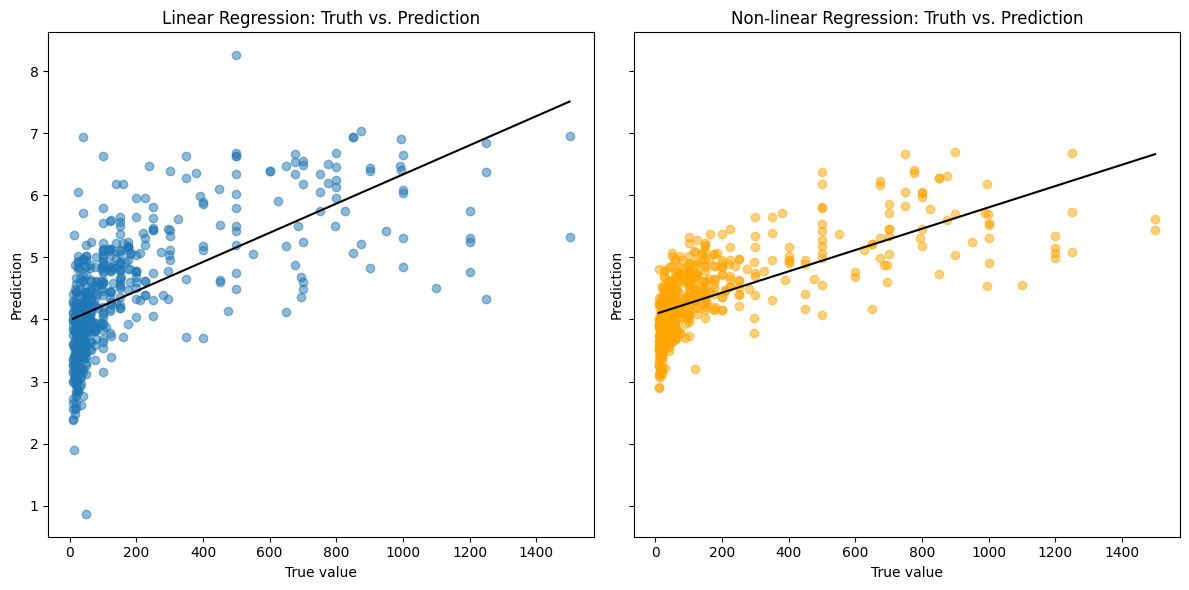

In [874]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Linear regression plot
axes[0].scatter(y_test, linear_y_pred, alpha=0.5)
axes[0].plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, linear_y_pred, 1))(np.unique(y_test)), c="black")
axes[0].set_xlabel("True value")
axes[0].set_ylabel("Prediction")
axes[0].set_title("Linear Regression: Truth vs. Prediction")

# Non-linear regression plot
axes[1].scatter(y_test, non_linear_y_pred, alpha=0.5, color="orange")
axes[1].plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, non_linear_y_pred, 1))(np.unique(y_test)), c="black")
axes[1].set_xlabel("True value")
axes[1].set_ylabel("Prediction")
axes[1].set_title("Non-linear Regression: Truth vs. Prediction")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [875]:
def label_coef(c, i):
    numeric_values.shape, text_features.shape, image_features.shape
    if i < numeric_values.shape[1]:
        return ("scraped feature", c, i, numeric_features[i])
    
    if numeric_values.shape[1] <= i < (text_features.shape[1] + numeric_values.shape[1]):
        return ("text feature", c, i, None)
    
    if i >= (text_features.shape[1] + numeric_values.shape[1]):
        return ("image feature", c, i, None)

In [876]:
coef_df = pd.DataFrame(sorted(
    [label_coef(c, i) for i, c in enumerate(abs(linreg_cv["estimator"][2].coef_))],
    key = lambda x : x[1],
    reverse = True),
    columns = ["feature source", "coef", "feature index", "feature name"])

In [877]:
coef_df = coef_df.reset_index().rename({"index": "order"}, axis = 1)

In [878]:
coef_df

,order,feature source,coef,feature index,feature name
0,0,image feature,1.211978e+01,531,None
1,1,image feature,9.228837e+00,657,None
2,2,image feature,6.808517e+00,616,None
3,3,image feature,4.744827e+00,641,None
4,4,image feature,4.696988e+00,535,None
...,...,...,...,...,...
655,655,scraped feature,5.551115e-16,302,location_stonington
656,656,scraped feature,4.440892e-16,352,location_wyoming
657,657,scraped feature,3.330669e-16,310,location_upton
658,658,scraped feature,0.000000e+00,323,location_warwick 3135 post rd . . rhyda tire


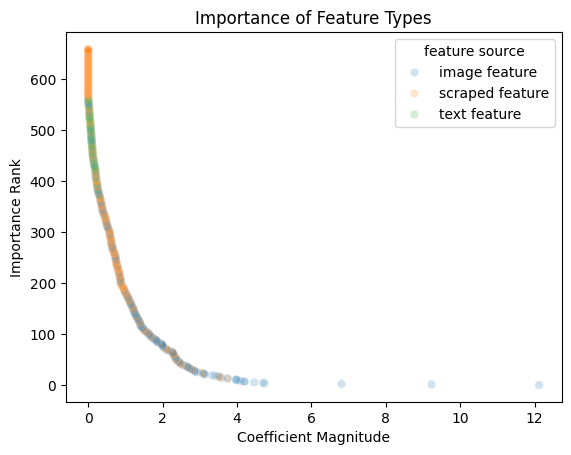

In [879]:
import seaborn as sns

sns.scatterplot(data = coef_df, x = "coef", y = "order", hue = "feature source", alpha = 0.2)
plt.title("Importance of Feature Types")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Importance Rank")
plt.savefig("../analysis_deliverable/visualizations/feature_importance.png")
pass
# coef_df[["order", "coef", "feature source"]].plot.scatter(x = "coef", y = "order", hue = "feature source")

In [880]:
### K-Means Clustering Analysis

In [881]:
def train_cluster(X, y, n_clusters = 10):
    kmeans = KMeans(n_clusters, random_state = 0)
    cluster_labels = kmeans.fit_predict(X)
    clusters = kmeans.cluster_centers_
    cluster_info = []
    for i in range(n_clusters):
        avg_cluster_price = np.mean(y[cluster_labels == i])
        num_values = sum(cluster_labels == i)
        cluster_info.append([avg_cluster_price, num_values])
    return pd.DataFrame(cluster_info, columns = ["average price in cluster", "num items in cluster"]), clusters, cluster_labels


In [882]:
cluster_df, cluster_centers, cluster_labels = train_cluster(all_features, target, 10)

In [883]:
cluster_price_df = pd.DataFrame(data = [cluster_labels, target], index = ["Cluster Label", "Price"]).T

Text(0.5, 1.0, 'Price Distribution in KMeans Clusters (All Features)')

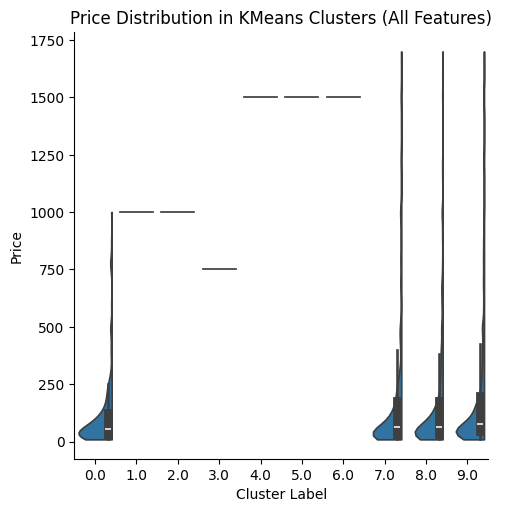

In [884]:
import seaborn as sns

sns.catplot(data = cluster_price_df, y="Price", x="Cluster Label",
    kind="violin", bw_adjust=.5, cut=0, split=True,)
plt.title("Price Distribution in KMeans Clusters (All Features)")

Text(0.5, 1.0, 'Price Distribution in KMeans Clusters (Webscraped Features)')

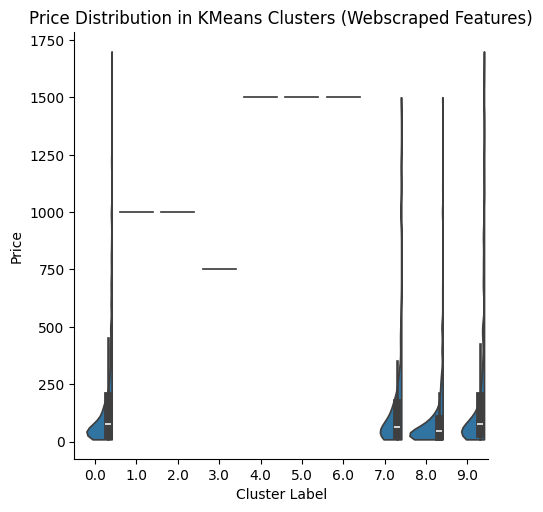

In [885]:
cluster_df, cluster_centers, cluster_labels = train_cluster(numeric_values[mask], target, 10)
cluster_price_df = pd.DataFrame(data = [cluster_labels, target], index = ["Cluster Label", "Price"]).T

sns.catplot(data = cluster_price_df, y="Price", x="Cluster Label",
    kind="violin", bw_adjust=.5, cut=0, split=True,)
plt.title("Price Distribution in KMeans Clusters (Webscraped Features)")

Text(0.5, 1.0, 'Price Distribution in KMeans Clusters (Image Features)')

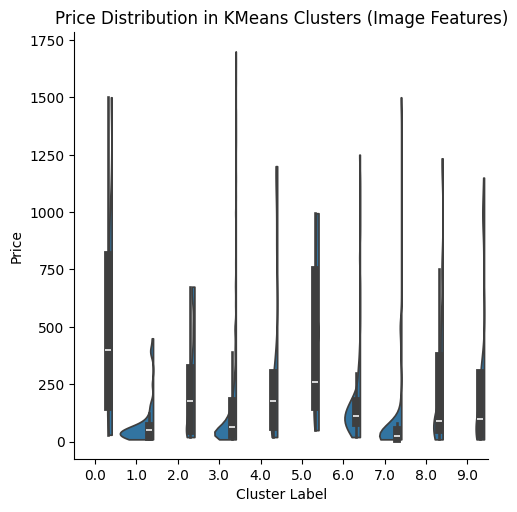

In [886]:
cluster_df, cluster_centers, cluster_labels = train_cluster(image_features[mask], target, 10)
cluster_price_df = pd.DataFrame(data = [cluster_labels, target], index = ["Cluster Label", "Price"]).T

sns.catplot(data = cluster_price_df, y="Price", x="Cluster Label",
    kind="violin", bw_adjust=.5, cut=0, split=True,)
plt.title("Price Distribution in KMeans Clusters (Image Features)")

Text(0.5, 1.0, 'Price Distribution in KMeans Clusters (Text Features)')

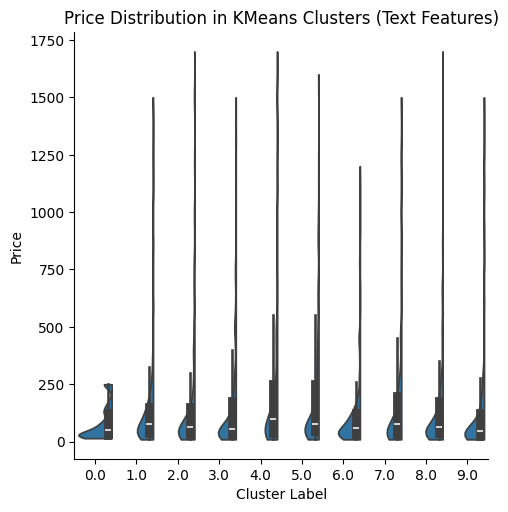

In [887]:
cluster_df, cluster_centers, cluster_labels = train_cluster(text_features[mask], target, 10)
cluster_price_df = pd.DataFrame(data = [cluster_labels, target], index = ["Cluster Label", "Price"]).T

sns.catplot(data = cluster_price_df, y="Price", x="Cluster Label",
    kind="violin", bw_adjust=.5, cut=0, split=True,)
plt.title("Price Distribution in KMeans Clusters (Text Features)")